In [1]:
import numpy as np
#import pandas as pd
import sklearn as skl
from hmmlearn import hmm
from scipy.misc import logsumexp
from sklearn.externals import joblib
from sklearn.cluster import SpectralClustering
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#sns.set(rc={'text.usetex' : True})
%matplotlib inline

In [21]:
DATA_DIR = '../data/trajdata_i101_trajectories-0750am-0805am/'
traj_lens = np.loadtxt(DATA_DIR + 'traj_lengths.csv', dtype=np.int)

In [40]:
n_trajs = len(traj_lens)
n_components = 5

In [8]:
D = np.loadtxt(DATA_DIR + 'X_disc.csv', delimiter=',', dtype=np.int)

n_samples = D.shape[0]

obs = set()
for i in range(n_samples):
    obs.add(tuple(D[i]))

obs_lut = dict()
for (i, o) in enumerate(obs):
    obs_lut[o] = i

n_features = len(obs_lut)
X = np.apply_along_axis(lambda o: obs_lut[tuple(o)], axis=1, arr=D)
X = X[:, np.newaxis]

In [9]:
model = hmm.MultinomialHMM(n_components=n_components, n_iter=75)
model.n_features = n_features

In [25]:
model.monitor_.verbose = True

In [23]:
model.fit(X, lengths=traj_lens)
loglike = model.monitor_.history[1]
model.monitor_.converged

In [125]:
loglike

-6132175.9311948335

In [78]:
joblib.dump(model, DATA_DIR + 'm' + str(abs(int(loglike))) + '.pkl')

['../data/trajdata_i101_trajectories-0750am-0805am/6132175.pkl']

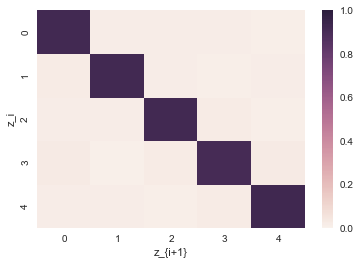

In [29]:
ax = sns.heatmap(model.transmat_, vmin=0, vmax=1)
ax.set(xlabel='z_{i+1}', ylabel='z_i')

In [45]:
As = np.zeros((n_trajs, n_components, n_components))
for s, (i, j) in enumerate(hmm.iter_from_X_lengths(X, traj_lens)):
    # s is the trajectory number
    framelogprob = model._compute_log_likelihood(X[i:j])
    _, fwdlattice = model._do_forward_pass(framelogprob)
    bwdlattice = model._do_backward_pass(framelogprob)
    # skip the last timestep thingy
    temp = np.zeros((n_components, n_components))
    for t in range(j-i-1):
        temp = fwdlattice[t, :, np.newaxis] + model.transmat_ + bwdlattice[t+1] + framelogprob[t+1]
        temp -= logsumexp(temp)
        As[s] += np.exp(temp)
    As[s] /= As[s].sum(0, keepdims=True)

In [71]:
D = np.empty((n_trajs, n_trajs))

# number of trajectories around a trajectory to consider 
look_ahead = 150

for i in range(n_trajs):
    for j in range(i, n_trajs):
        D[i, j] = np.log(n_components) * np.sum(np.sqrt(As[i] * As[j]))
        D[j, i] = D[i, j]

''

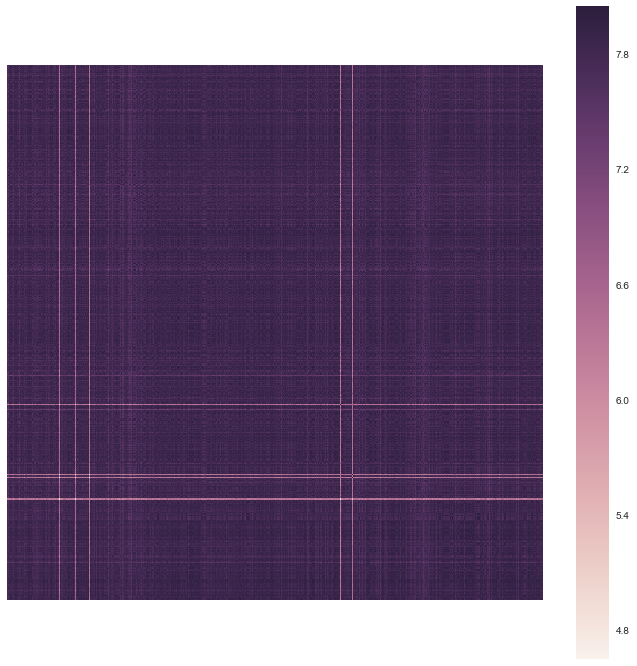

In [132]:
plt.figure(figsize=(10,10))
fig = plt.figure(figsize=(12,12))
ax = fig.gca()
sns.heatmap(D, square=True)
ax.set_xticks([])
ax.set_yticks([])
;

### Clustering

In [119]:
y = skl.cluster.spectral_clustering(D, n_clusters=10)

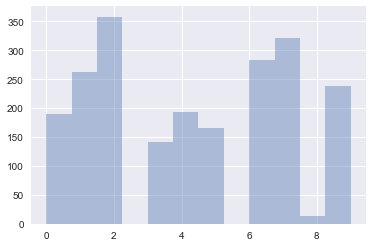

In [122]:
sns.distplot(y, kde=False)